### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [3]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [32]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    contexts = []
    targets = []
    for i in range(len(corpus)):
      if i == 0:
        for j in range(1,window_size+1):
          targets.append(corpus[i+j])
      elif i == len(corpus)-1:
        for j in range(1,window_size+1):
          targets.append(corpus[i-j])
      else:
        for j in range(1,window_size+1):
          targets.append(corpus[i+j])
          targets.append(corpus[i-j])
    
    for i in range(len(corpus)):
      if i == 0:
        for j in range(1,window_size+1):
          contexts.append([corpus[i]])
      elif i == len(corpus)-1:
        for j in range(1,window_size+1):
          contexts.append([corpus[i]])
      else:
        for j in range(1,2*window_size+1):
          contexts.append([corpus[i]])

    return np.array(contexts), np.array(targets)

# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
print(corpus[0])
contexts, targets

[0 1 6 2 5 3 7 4]


(array([[0],
        [1],
        [1],
        [6],
        [6],
        [2],
        [2],
        [5],
        [5],
        [3],
        [3],
        [7],
        [7],
        [4]]), array([1, 6, 0, 2, 1, 5, 6, 3, 2, 7, 5, 4, 3, 7]))

In [33]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[[1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 1, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 1, 0, 0, 0]]], dtype=int32),
 array([[0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0

In [54]:
print(contexts.shape)
contexts[:,0]

(14, 1, 8)


array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int32)

In [79]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size*2)]
        
        layers = [self.in_layer] + [self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts[:, 0])
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size*2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size*2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [80]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(vocab_size=len(word2idx), hidden_size=hidden_size, window_size=window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 10%|█         | 100/1000 [00:00<00:01, 496.14it/s]

Epoch: 1, Iteration: 1/4, Loss: 4.158488571457792
Epoch: 2, Iteration: 1/4, Loss: 4.158656043154691
Epoch: 3, Iteration: 1/4, Loss: 4.158278172033333
Epoch: 4, Iteration: 1/4, Loss: 4.158303075089955
Epoch: 5, Iteration: 1/4, Loss: 4.1576246817902955
Epoch: 6, Iteration: 1/4, Loss: 4.1574435402318635
Epoch: 7, Iteration: 1/4, Loss: 4.156243718514758
Epoch: 8, Iteration: 1/4, Loss: 4.153768352601473
Epoch: 9, Iteration: 1/4, Loss: 4.153244258803234
Epoch: 10, Iteration: 1/4, Loss: 4.145073992238044
Epoch: 11, Iteration: 1/4, Loss: 4.141163262619826
Epoch: 12, Iteration: 1/4, Loss: 4.13060979667684
Epoch: 13, Iteration: 1/4, Loss: 4.114940024952465
Epoch: 14, Iteration: 1/4, Loss: 4.071769348726381
Epoch: 15, Iteration: 1/4, Loss: 4.04405448791494
Epoch: 16, Iteration: 1/4, Loss: 4.0064084971363645
Epoch: 17, Iteration: 1/4, Loss: 3.8228307152670027
Epoch: 18, Iteration: 1/4, Loss: 3.7357321131136194
Epoch: 19, Iteration: 1/4, Loss: 3.4851030618839864
Epoch: 20, Iteration: 1/4, Loss: 3.1

 20%|██        | 203/1000 [00:00<00:01, 501.95it/s]

Epoch: 104, Iteration: 1/4, Loss: 0.2617223788893197
Epoch: 105, Iteration: 1/4, Loss: 0.42820882101156194
Epoch: 106, Iteration: 1/4, Loss: 0.46702759083013157
Epoch: 107, Iteration: 1/4, Loss: 0.5933860014259165
Epoch: 108, Iteration: 1/4, Loss: 0.46064023188289516
Epoch: 109, Iteration: 1/4, Loss: 0.7343603376395407
Epoch: 110, Iteration: 1/4, Loss: 0.3353666537353249
Epoch: 111, Iteration: 1/4, Loss: 0.7586322350338017
Epoch: 112, Iteration: 1/4, Loss: 0.11854340494881462
Epoch: 113, Iteration: 1/4, Loss: 0.7103219520323237
Epoch: 114, Iteration: 1/4, Loss: 0.5623974750281993
Epoch: 115, Iteration: 1/4, Loss: 0.47803306059986034
Epoch: 116, Iteration: 1/4, Loss: 0.5744272106002004
Epoch: 117, Iteration: 1/4, Loss: 0.5538559168028718
Epoch: 118, Iteration: 1/4, Loss: 0.4297349894154384
Epoch: 119, Iteration: 1/4, Loss: 0.5558829053341372
Epoch: 120, Iteration: 1/4, Loss: 0.43568604349984336
Epoch: 121, Iteration: 1/4, Loss: 0.6889751596625093
Epoch: 122, Iteration: 1/4, Loss: 0.5387

 30%|███       | 301/1000 [00:00<00:01, 493.79it/s]

Epoch: 210, Iteration: 1/4, Loss: 0.3165923474273534
Epoch: 211, Iteration: 1/4, Loss: 0.20248520565129097
Epoch: 212, Iteration: 1/4, Loss: 0.4464690122930292
Epoch: 213, Iteration: 1/4, Loss: 0.5279574676640862
Epoch: 214, Iteration: 1/4, Loss: 0.5182062827254761
Epoch: 215, Iteration: 1/4, Loss: 0.40839562544764263
Epoch: 216, Iteration: 1/4, Loss: 0.4072072550861443
Epoch: 217, Iteration: 1/4, Loss: 0.31785088609849177
Epoch: 218, Iteration: 1/4, Loss: 0.7597470439091616
Epoch: 219, Iteration: 1/4, Loss: 0.39412051703982454
Epoch: 220, Iteration: 1/4, Loss: 0.5065645886519088
Epoch: 221, Iteration: 1/4, Loss: 0.5273934129873303
Epoch: 222, Iteration: 1/4, Loss: 0.34656921978868427
Epoch: 223, Iteration: 1/4, Loss: 0.37933735725432544
Epoch: 224, Iteration: 1/4, Loss: 0.7259912441862171
Epoch: 225, Iteration: 1/4, Loss: 0.527859697055343
Epoch: 226, Iteration: 1/4, Loss: 0.34518283774341546
Epoch: 227, Iteration: 1/4, Loss: 0.3602133685958732
Epoch: 228, Iteration: 1/4, Loss: 0.6065

 40%|████      | 403/1000 [00:00<00:01, 499.46it/s]

Epoch: 311, Iteration: 1/4, Loss: 0.3175716234003685
Epoch: 312, Iteration: 1/4, Loss: 0.46610030996522833
Epoch: 313, Iteration: 1/4, Loss: 0.3642955548354106
Epoch: 314, Iteration: 1/4, Loss: 0.590782156164368
Epoch: 315, Iteration: 1/4, Loss: 0.275474527937897
Epoch: 316, Iteration: 1/4, Loss: 0.7240966709906498
Epoch: 317, Iteration: 1/4, Loss: 0.40320717684387414
Epoch: 318, Iteration: 1/4, Loss: 0.2673430309873599
Epoch: 319, Iteration: 1/4, Loss: 0.5259437493845848
Epoch: 320, Iteration: 1/4, Loss: 0.45811600427001153
Epoch: 321, Iteration: 1/4, Loss: 0.30939319337548693
Epoch: 322, Iteration: 1/4, Loss: 0.4637552083913407
Epoch: 323, Iteration: 1/4, Loss: 0.3338799052661258
Epoch: 324, Iteration: 1/4, Loss: 0.573034155033304
Epoch: 325, Iteration: 1/4, Loss: 0.5816884304251447
Epoch: 326, Iteration: 1/4, Loss: 0.4004721500803152
Epoch: 327, Iteration: 1/4, Loss: 0.6121018356161934
Epoch: 328, Iteration: 1/4, Loss: 0.513640861115717
Epoch: 329, Iteration: 1/4, Loss: 0.5085777455

 50%|████▉     | 499/1000 [00:01<00:01, 486.99it/s]

Epoch: 417, Iteration: 1/4, Loss: 0.44528881153846506
Epoch: 418, Iteration: 1/4, Loss: 0.40547509615612043
Epoch: 419, Iteration: 1/4, Loss: 0.3815397354895733
Epoch: 420, Iteration: 1/4, Loss: 0.5133550798767139
Epoch: 421, Iteration: 1/4, Loss: 0.43782696405952926
Epoch: 422, Iteration: 1/4, Loss: 0.47474577040851096
Epoch: 423, Iteration: 1/4, Loss: 0.2595147003987188
Epoch: 424, Iteration: 1/4, Loss: 0.48483333957587027
Epoch: 425, Iteration: 1/4, Loss: 0.2536224299357461
Epoch: 426, Iteration: 1/4, Loss: 0.5068935272989443
Epoch: 427, Iteration: 1/4, Loss: 0.17203331656184642
Epoch: 428, Iteration: 1/4, Loss: 0.554159247251187
Epoch: 429, Iteration: 1/4, Loss: 0.32075168475583243
Epoch: 430, Iteration: 1/4, Loss: 0.5873367747137465
Epoch: 431, Iteration: 1/4, Loss: 0.1393686702016251
Epoch: 432, Iteration: 1/4, Loss: 0.47480725812578756
Epoch: 433, Iteration: 1/4, Loss: 0.3458657668194156
Epoch: 434, Iteration: 1/4, Loss: 0.5895034737614311
Epoch: 435, Iteration: 1/4, Loss: 0.320

 59%|█████▉    | 594/1000 [00:01<00:00, 459.98it/s]

Epoch: 517, Iteration: 1/4, Loss: 0.40428840301459856
Epoch: 518, Iteration: 1/4, Loss: 0.48336822993181394
Epoch: 519, Iteration: 1/4, Loss: 0.34564288571711327
Epoch: 520, Iteration: 1/4, Loss: 0.5015027309961587
Epoch: 521, Iteration: 1/4, Loss: 0.4753221623876077
Epoch: 522, Iteration: 1/4, Loss: 0.40696617649696853
Epoch: 523, Iteration: 1/4, Loss: 0.5783519218321971
Epoch: 524, Iteration: 1/4, Loss: 0.36439473884194673
Epoch: 525, Iteration: 1/4, Loss: 0.4575681221675346
Epoch: 526, Iteration: 1/4, Loss: 0.6608841442860921
Epoch: 527, Iteration: 1/4, Loss: 0.3082222098138198
Epoch: 528, Iteration: 1/4, Loss: 0.41061461268301763
Epoch: 529, Iteration: 1/4, Loss: 0.5504435354296213
Epoch: 530, Iteration: 1/4, Loss: 0.3114177308597481
Epoch: 531, Iteration: 1/4, Loss: 0.38227263624671914
Epoch: 532, Iteration: 1/4, Loss: 0.631072768031619
Epoch: 533, Iteration: 1/4, Loss: 0.21306341084061858
Epoch: 534, Iteration: 1/4, Loss: 0.48813532296079815
Epoch: 535, Iteration: 1/4, Loss: 0.14

 70%|██████▉   | 696/1000 [00:01<00:00, 483.08it/s]

Epoch: 608, Iteration: 1/4, Loss: 0.30893741244774564
Epoch: 609, Iteration: 1/4, Loss: 0.6781538529954735
Epoch: 610, Iteration: 1/4, Loss: 0.3573142333782838
Epoch: 611, Iteration: 1/4, Loss: 0.39194152507758934
Epoch: 612, Iteration: 1/4, Loss: 0.4449031816303202
Epoch: 613, Iteration: 1/4, Loss: 0.48922402975460627
Epoch: 614, Iteration: 1/4, Loss: 0.5351569811947803
Epoch: 615, Iteration: 1/4, Loss: 0.6221357815041921
Epoch: 616, Iteration: 1/4, Loss: 0.34013411001276384
Epoch: 617, Iteration: 1/4, Loss: 0.5276371382952469
Epoch: 618, Iteration: 1/4, Loss: 0.26274086530728397
Epoch: 619, Iteration: 1/4, Loss: 0.5254135842757182
Epoch: 620, Iteration: 1/4, Loss: 0.5830388748536486
Epoch: 621, Iteration: 1/4, Loss: 0.5377835016616186
Epoch: 622, Iteration: 1/4, Loss: 0.3175089368054005
Epoch: 623, Iteration: 1/4, Loss: 0.403184704039143
Epoch: 624, Iteration: 1/4, Loss: 0.4204522041601698
Epoch: 625, Iteration: 1/4, Loss: 0.5096723620023693
Epoch: 626, Iteration: 1/4, Loss: 0.279069

 79%|███████▉  | 793/1000 [00:01<00:00, 464.75it/s]

Epoch: 714, Iteration: 1/4, Loss: 0.37406208328360613
Epoch: 715, Iteration: 1/4, Loss: 0.2688821427776145
Epoch: 716, Iteration: 1/4, Loss: 0.45499144402041614
Epoch: 717, Iteration: 1/4, Loss: 0.4229198148303168
Epoch: 718, Iteration: 1/4, Loss: 0.4386249060751331
Epoch: 719, Iteration: 1/4, Loss: 0.16485536269592088
Epoch: 720, Iteration: 1/4, Loss: 0.6029448863125252
Epoch: 721, Iteration: 1/4, Loss: 0.5082367835521814
Epoch: 722, Iteration: 1/4, Loss: 0.37632146803978295
Epoch: 723, Iteration: 1/4, Loss: 0.5104785402236013
Epoch: 724, Iteration: 1/4, Loss: 0.5457813762889251
Epoch: 725, Iteration: 1/4, Loss: 0.26132180642433445
Epoch: 726, Iteration: 1/4, Loss: 0.6241752866533495
Epoch: 727, Iteration: 1/4, Loss: 0.43902916497034483
Epoch: 728, Iteration: 1/4, Loss: 0.7737354647608476
Epoch: 729, Iteration: 1/4, Loss: 0.20732439068948916
Epoch: 730, Iteration: 1/4, Loss: 0.6223690217163969
Epoch: 731, Iteration: 1/4, Loss: 0.587457730124658
Epoch: 732, Iteration: 1/4, Loss: 0.3884

 89%|████████▉ | 888/1000 [00:01<00:00, 468.96it/s]

Epoch: 809, Iteration: 1/4, Loss: 0.45647778080662005
Epoch: 810, Iteration: 1/4, Loss: 0.40530572173939616
Epoch: 811, Iteration: 1/4, Loss: 0.5238053317390123
Epoch: 812, Iteration: 1/4, Loss: 0.3638247960921141
Epoch: 813, Iteration: 1/4, Loss: 0.20520523484072808
Epoch: 814, Iteration: 1/4, Loss: 0.5025653871779556
Epoch: 815, Iteration: 1/4, Loss: 0.521635780806414
Epoch: 816, Iteration: 1/4, Loss: 0.5619521364884873
Epoch: 817, Iteration: 1/4, Loss: 0.4608394019526589
Epoch: 818, Iteration: 1/4, Loss: 0.5504460164084756
Epoch: 819, Iteration: 1/4, Loss: 0.40416472059344477
Epoch: 820, Iteration: 1/4, Loss: 0.39223040422810335
Epoch: 821, Iteration: 1/4, Loss: 0.323278918556414
Epoch: 822, Iteration: 1/4, Loss: 0.25257622352383596
Epoch: 823, Iteration: 1/4, Loss: 0.3703153291736745
Epoch: 824, Iteration: 1/4, Loss: 0.16064422548869126
Epoch: 825, Iteration: 1/4, Loss: 0.39658562250350093
Epoch: 826, Iteration: 1/4, Loss: 0.3234474479085807
Epoch: 827, Iteration: 1/4, Loss: 0.6643

100%|██████████| 1000/1000 [00:02<00:00, 481.68it/s]

Epoch: 908, Iteration: 1/4, Loss: 0.5100802109461231
Epoch: 909, Iteration: 1/4, Loss: 0.24798242751345495
Epoch: 910, Iteration: 1/4, Loss: 0.3133215784704402
Epoch: 911, Iteration: 1/4, Loss: 0.5611589262184844
Epoch: 912, Iteration: 1/4, Loss: 0.14907555836634023
Epoch: 913, Iteration: 1/4, Loss: 0.626096593035386
Epoch: 914, Iteration: 1/4, Loss: 0.25637432046597886
Epoch: 915, Iteration: 1/4, Loss: 0.5156585527892928
Epoch: 916, Iteration: 1/4, Loss: 0.4979316522363805
Epoch: 917, Iteration: 1/4, Loss: 0.3212331279682825
Epoch: 918, Iteration: 1/4, Loss: 0.5169617856282768
Epoch: 919, Iteration: 1/4, Loss: 0.18029737723631872
Epoch: 920, Iteration: 1/4, Loss: 0.8491043202493227
Epoch: 921, Iteration: 1/4, Loss: 0.2334763585330529
Epoch: 922, Iteration: 1/4, Loss: 0.3578971806114254
Epoch: 923, Iteration: 1/4, Loss: 0.3576615898603031
Epoch: 924, Iteration: 1/4, Loss: 0.5811988422924846
Epoch: 925, Iteration: 1/4, Loss: 0.2533567139725492
Epoch: 926, Iteration: 1/4, Loss: 0.4463513

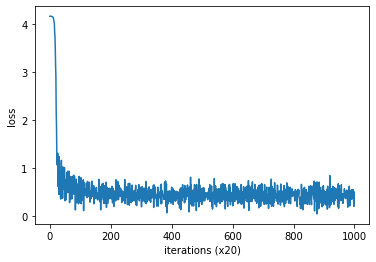

In [81]:
trainer.plot()

In [82]:
# check skip-gram results
word_vecs = skip_gram.word_vecs
for word_id, word in idx2word.items():
    print(word, word_vecs[word_id])

i [-1.3188341  -0.06129954  0.0764495   0.46263343  1.4760784 ]
am [-1.0971133   0.36952883  0.02110224  0.61160105  1.1064706 ]
natural [-1.0411665   1.978562   -0.06479209  1.3245575   0.5649377 ]
processing [-1.0720277   1.9766482  -0.07806686  1.3315717   0.55316114]
. [-0.94082725  1.7792118  -0.06809093  1.1797637   0.46242306]
language [-1.0498555   1.9793514  -0.08117115  1.32607     0.5629284 ]
studying [-1.0705537   0.2626762   0.02358653  0.55539984  1.1258237 ]
now [-1.0677716   1.9833388  -0.09240662  1.3213142   0.56408954]
